### Importation des bibliothèques nécessaires

In [240]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [241]:
# Path du dataset
dataset_path = "C:\\Users\\yanis\\OneDrive\\Bureau\\Liv1_dataset"

#### Variables gobale

In [242]:
data_dir = dataset_path
image_h = 180
image_w = 180
batch_s = 32
num_samples = 1000
epochs = 10

#### Collecte de données sur les images et création d'un DataFrame avec leurs caractéristiques

In [121]:
image_data = []

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    
    for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            if file == "desktop.ini":
                continue
            with Image.open(file_path) as image:
                image_data.append({
                    "FileName": file,
                    "Width": float(image.size[0]),
                    "Height": float(image.size[1]),
                    "Mode": image.mode,
                    "Category": folder,
                })

    print(f"Le dossier '{folder}' a été lu.")

images = pd.DataFrame(image_data)
images


Le dossier 'Painting' a été lu.
Le dossier 'Photo' a été lu.
Le dossier 'Schematics' a été lu.
Le dossier 'Sketch' a été lu.
Le dossier 'Text' a été lu.


,FileName,Width,Height,Mode,Category
0,painting_00001.jpg,710.0,768.0,RGB,Painting
1,painting_00002.jpg,597.0,561.0,RGB,Painting
2,painting_00003.jpg,750.0,600.0,RGB,Painting
3,painting_00004.jpg,1000.0,490.0,RGB,Painting
4,painting_00005.jpg,429.0,570.0,RGB,Painting
...,...,...,...,...,...
41394,text_09996.jpg,595.0,842.0,RGB,Text
41395,text_09997.jpg,595.0,842.0,RGB,Text
41396,text_09998.jpg,595.0,792.0,RGB,Text
41397,text_09999.jpg,595.0,792.0,RGB,Text


#### Analyse des modes de couleur dans le dataset d'images

In [42]:
images = pd.DataFrame(image_data)
modes_count = images["Mode"].value_counts().reset_index()
modes_count.columns = ["Mode", "Nombre"]
print("Le modes present dans notre dataset : ")
unique_modes = images["Mode"].unique()
print(unique_modes)
print(modes_count)

Le modes present dans notre dataset : 
['RGB' 'L' 'P' 'CMYK' 'RGBA']
   Mode  Nombre
0   RGB   40297
1     L    1091
2     P       5
3  RGBA       5
4  CMYK       1


#### Nombre d'images par catégorie dans le dataset

In [95]:
#Nombre d'image par categorie
category_names = []
image_counts = []

dataset_dir = os.listdir(dataset_path)

for directory in dataset_dir:
    files=os.listdir(os.path.join(dataset_path, directory))
    image_count = len(list(files))
    category_names.append(directory)
    image_counts.append(image_count)
    print("Nombre d'images dans "+ directory +" :", image_count)

Nombre d'images dans Painting : 10000
Nombre d'images dans Photo : 9993
Nombre d'images dans Schematics : 10001
Nombre d'images dans Sketch : 1406
Nombre d'images dans Text : 10000


#### Visualisation du nombre d'images par catégorie dans le dataset

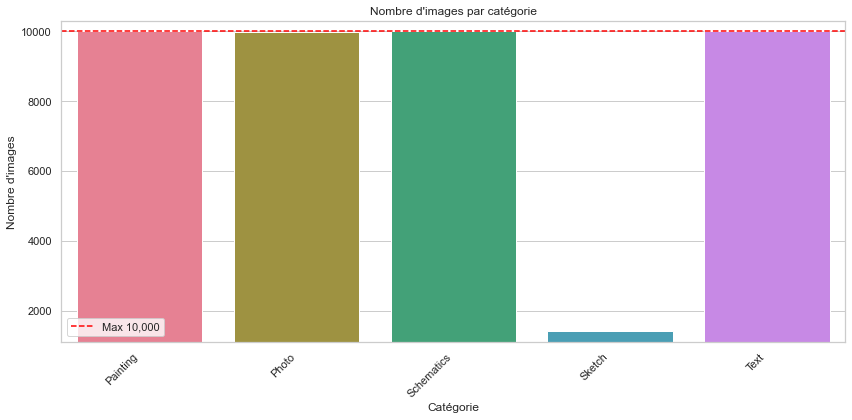

In [44]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.barplot(x=category_names, y=image_counts, palette="husl", linewidth=1)
plt.xlabel('Catégorie')
plt.ylabel('Nombre d\'images')
plt.title('Nombre d\'images par catégorie')
plt.xticks(rotation=45, ha="right")

plt.ylim(min(image_counts) - 300, max(image_counts) + 300)
plt.axhline(y=10000, color='red', linestyle='--', label='Max 10,000')

plt.tight_layout()
plt.legend()
plt.show()


#### Liste des extensions de fichiers présentes dans le dataset

In [45]:
#Toutes les extension possibles de notre dataset
import os

extensions = []

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)

    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        file_extension = os.path.splitext(file)[1]

        if file_extension not in extensions:
            extensions.append(file_extension)

print("Extensions possibles dans le dataset :")
for extension in extensions:
    print(extension)
    


Extensions possibles dans le dataset :
.jpg
.ini
.png


#### Création des ensembles de données d'entraînement et de validation à partir du répertoire d'images

In [250]:
def create_data_generator(directory, target_size, classes, subset):
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        zca_whitening=True,
        fill_mode='nearest',
        validation_split=0.2,
        channel_shift_range=0.2,
        brightness_range=(0.5, 1.5),
    )

    return datagen.flow_from_directory(
        directory=directory,
        target_size=target_size,
        classes=classes,
        class_mode="binary",
        subset=subset,
        batch_size=batch_s
    )

photos_gen = create_data_generator(dataset_path, (image_h, image_w), ["Photo"], "training")
others_gen = create_data_generator(dataset_path, (image_h, image_w), ["Text", "Sketch", "Schematics", "Painting"], "training")

photos_val_gen = create_data_generator(dataset_path, (image_h, image_w), ["Photo"], "validation")
others_val_gen = create_data_generator(dataset_path, (image_h, image_w), ["Text", "Sketch", "Schematics", "Painting"], "validation")


Found 7995 images belonging to 1 classes.
Found 25125 images belonging to 4 classes.
Found 1998 images belonging to 1 classes.
Found 6281 images belonging to 4 classes.


In [251]:
# Fusion des générateurs
def custom_merge_gen(photo_gen, other_gen):
    combined_data, combined_labels = [], []
    while True:
        photo_data, _ = photo_gen.next()
        other_data, _ = other_gen.next()

        # Création des labels
        photo_labels = np.ones(photo_data.shape[0])
        other_labels = np.zeros(other_data.shape[0])

        # Fusion des données et des labels
        combined_data = np.vstack((photo_data, other_data))
        combined_labels = np.hstack((photo_labels, other_labels))

        yield combined_data, combined_labels

train_generator = custom_merge_gen(photos_gen, others_gen)
val_generator = custom_merge_gen(photos_val_gen, others_val_gen)

In [187]:
#train_data, val_data, train_labels, val_labels = train_test_split(combined_data, combined_labels, test_size=0.2, stratify=combined_labels, random_state=42)

#### Configuration de la Data Augmentation pour l'Entraînement du Modèle

Augmentation de la diversité des données d'entraînement 

### Construction du Modèle de Réseau de Neurones Convolutif (CNN)

In [252]:
# Le modèle (avec 2 couches de convolution)
model_two_layer = Sequential([
  
  layers.Rescaling(1./255, input_shape=(image_h, image_w, 3)),
    
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Dropout(0.25),
    
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2,2), 
  layers.Dropout(0.25),
    
  layers.Flatten(),
    
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(1, activation='sigmoid')
])


In [253]:
# Résumé du modèle
model_two_layer.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_18 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_37 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_43 (Dropout)        (None, 90, 90, 32)        0         
                                                                 
 conv2d_38 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 45, 45, 64)        0         
 ng2D)                                               

#### Utilisation de l'Arrêt Précoce (Early Stopping) pour Améliorer l'Entraînement du Modèle

L'arrêt précoce (Early Stopping) est une technique utilisée lors de l'entraînement de modèles  pour prévenir le surajustement et améliorer la convergence du modèle

In [254]:
# Callback pour l'arrêt précoce
early_stopping = EarlyStopping(monitor='val_loss', patience=epochs, restore_best_weights=True)

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)
callbacks = [earlystop, learning_rate_reduction]

In [255]:
from tensorflow.keras.optimizers import Adam

# Compilation avec un taux d'apprentissage réduit
model_two_layer.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])


250
260


In [256]:
# Entraînement du modèle
history = model_two_layer.fit(
  train_generator,
  validation_data=val_generator,
  epochs=epochs,
  callbacks=callbacks,
  steps_per_epoch=photos_gen.samples//batch_s, validation_steps=photos_val_gen.samples//batch_s
)

Epoch 1/10
249/249 [==============================] - 611s 2s/step - loss: 0.5460 - accuracy: 0.7246 - val_loss: 0.5021 - val_accuracy: 0.7508 - lr: 0.0010
Epoch 2/10
249/249 [==============================] - 597s 2s/step - loss: 0.4965 - accuracy: 0.7625 - val_loss: 0.5320 - val_accuracy: 0.7379 - lr: 0.0010
Epoch 3/10
249/249 [==============================] - 594s 2s/step - loss: 0.4941 - accuracy: 0.7625 - val_loss: 0.4737 - val_accuracy: 0.7830 - lr: 0.0010
Epoch 4/10
249/249 [==============================] - 552s 2s/step - loss: 0.4820 - accuracy: 0.7728 - val_loss: 0.4932 - val_accuracy: 0.7688 - lr: 0.0010
Epoch 5/10
249/249 [==============================] - 536s 2s/step - loss: 0.4765 - accuracy: 0.7722 - val_loss: 0.4641 - val_accuracy: 0.7770 - lr: 0.0010
Epoch 6/10
249/249 [==============================] - 563s 2s/step - loss: 0.4828 - accuracy: 0.7649 - val_loss: 0.4651 - val_accuracy: 0.7697 - lr: 0.0010
Epoch 7/10
249/249 [==============================] - 533s 2s/st

In [257]:
model_two_layer.save('photo_classifier_model.h5')

C:\Users\yanis\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [258]:
from tensorflow.keras.models import load_model
model = load_model('photo_classifier_model.h5')

#### Visualisation de l'Évolution de l'Accuracy d'Entraînement et de Validation par Époque

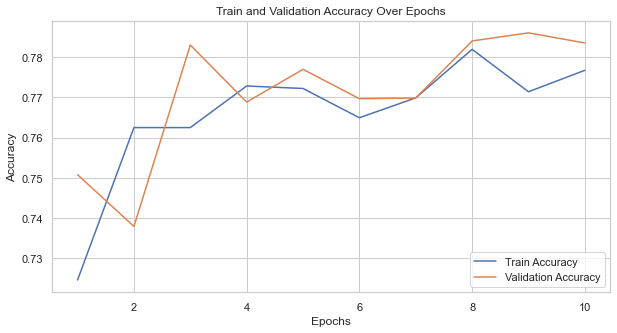

In [259]:
# Extraire les valeurs d'accuracy d'entraînement et de validation de l'historique
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Créer un graphique pour visualiser l'accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_accuracy, label='Train Accuracy')  # Remplacez 11 par le nombre total d'epochs
plt.plot(range(1, epochs+1), val_accuracy, label='Validation Accuracy')  # Remplacez 11 par le nombre total d'epochs
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [270]:
from tensorflow.keras.preprocessing import image

img_path = 'C:\\Users\\yanis\\OneDrive\\Bureau\\img_test\\painting_2.jpg'
img = image.load_img(img_path, target_size=(image_h, image_w))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

prediction = model.predict(img_array)
print(prediction)
predicted_class = (prediction > 0.6).astype("int32")  # 1 pour "Photo", 0 pour "Autres"

print(f"Predicted Class: {'Photo' if predicted_class[0][0] == 1 else 'Others'}")

1/1 [==============================] - 0s 66ms/step
[[0.5148003]]
Predicted Class: Others


1/1 [==============================] - 0s 54ms/step


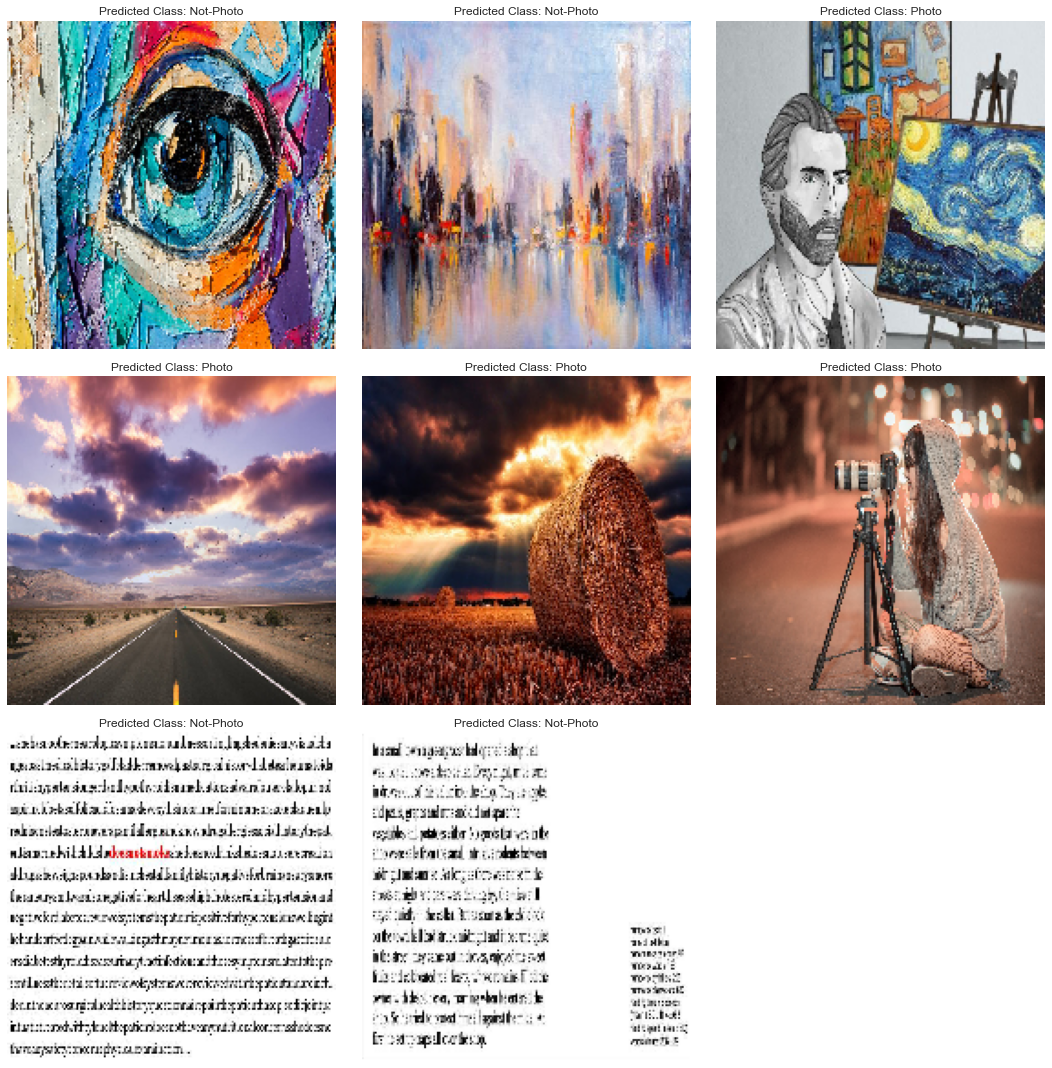

In [274]:
from tensorflow.keras.preprocessing import image
import os
import matplotlib.pyplot as plt

# Liste des chemins d'accès aux images
image_paths = [
    'C:\\Users\\yanis\\OneDrive\\Bureau\\img_test\\painting_1.jpg',
    'C:\\Users\\yanis\\OneDrive\\Bureau\\img_test\\painting_2.jpg',
    'C:\\Users\\yanis\\OneDrive\\Bureau\\img_test\\painting_3.jpg',
    'C:\\Users\\yanis\\OneDrive\\Bureau\\img_test\\photo_1.jpg',
    'C:\\Users\\yanis\\OneDrive\\Bureau\\img_test\\photo_2.jpg',
    'C:\\Users\\yanis\\OneDrive\\Bureau\\img_test\\photo_3.jpg',
    'C:\\Users\\yanis\\OneDrive\\Bureau\\img_test\\text_1.jpg',
    'C:\\Users\\yanis\\OneDrive\\Bureau\\img_test\\text_2.jpg',
]

# Définir le nombre de colonnes pour l'affichage horizontal
num_columns = 3
num_rows = (len(image_paths) + num_columns - 1) // num_columns

# Créer une figure avec plusieurs sous-plots horizontaux
plt.figure(figsize=(15, 5 * num_rows))

for i, img_path in enumerate(image_paths):
    # Charger l'image
    img = image.load_img(img_path, target_size=(image_h, image_w))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Prédiction
    prediction = model.predict(img_array)
    predicted_class = (prediction > 0.6).astype("int32")  # 1 pour "Photo", 0 pour "Autres"

    # Afficher l'image et la prédiction dans un sous-plot
    plt.subplot(num_rows, num_columns, i + 1)
    plt.imshow(img)
    plt.title(f"Predicted Class: {'Photo' if predicted_class[0][0] == 1 else 'Not-Photo'}")
    plt.axis('off')

# Ajuster l'espacement entre les sous-plots
plt.tight_layout()
plt.show()
